In [56]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [57]:
#保存打印文件
f = open("1.2torchRNN.txt", 'a+')

In [58]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

data = np.load("./实验4-数据/高速公路传感器数据/PEMS04/PEMS04.npz")
#因为数据集过大，这里只取了第一个传感器的数据
data = data["data"][:,0:1,0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)
sensordata_num,sensor_num,_ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set += sliding_window(train_seq,window_size=13)
    test_set += sliding_window(test_seq,window_size=13)
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


In [59]:
device = 'cpu'
rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(32, 1), nn.LeakyReLU()).to(device)

In [60]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(out_linear.parameters()), lr=0.0001)

In [61]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [62]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [63]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

In [64]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = out_linear(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = rnn(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = out_linear(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 0.199442,Time used 0.015957s
batch 2, train_loss 0.216235,Time used 0.006982s
batch 3, train_loss 0.187134,Time used 0.006981s
batch 4, train_loss 0.202706,Time used 0.005983s
batch 5, train_loss 0.207787,Time used 0.006982s
batch 6, train_loss 0.204988,Time used 0.006981s
batch 7, train_loss 0.203030,Time used 0.006981s
batch 8, train_loss 0.213959,Time used 0.006982s
batch 9, train_loss 0.201289,Time used 0.006982s
batch 10, train_loss 0.206352,Time used 0.006982s
batch 11, train_loss 0.223462,Time used 0.006981s
batch 12, train_loss 0.205061,Time used 0.006981s
batch 13, train_loss 0.189630,Time used 0.006981s
batch 14, train_loss 0.198364,Time used 0.006982s
batch 15, train_loss 0.181313,Time used 0.006981s
batch 16, train_loss 0.177073,Time used 0.006981s
batch 17, train_loss 0.181610,Time used 0.005984s
batch 18, train_loss 0.189933,Time used 0.006981s
batch 19, train_loss 0.196790,Time used 0.006981s
batch 20, train_loss 0.204687,Time used 0.006981s
batch 21,

batch 165, train_loss 0.033676,Time used 0.006982s
batch 166, train_loss 0.037184,Time used 0.006981s
batch 167, train_loss 0.028131,Time used 0.006981s
batch 168, train_loss 0.031018,Time used 0.006981s
batch 169, train_loss 0.033953,Time used 0.005984s
batch 170, train_loss 0.034822,Time used 0.006980s
batch 171, train_loss 0.038874,Time used 0.006982s
batch 172, train_loss 0.038428,Time used 0.005984s
batch 173, train_loss 0.034030,Time used 0.005983s
batch 174, train_loss 0.039312,Time used 0.006982s
batch 175, train_loss 0.029784,Time used 0.006981s
batch 176, train_loss 0.038393,Time used 0.006981s
batch 177, train_loss 0.034499,Time used 0.006981s
batch 178, train_loss 0.033256,Time used 0.005984s
batch 179, train_loss 0.034299,Time used 0.006980s
batch 180, train_loss 0.035678,Time used 0.006981s
batch 181, train_loss 0.030368,Time used 0.006980s
batch 182, train_loss 0.032828,Time used 0.006982s
batch 183, train_loss 0.034257,Time used 0.006982s
batch 184, train_loss 0.032602,

batch 323, train_loss 0.019776,Time used 0.006981s
batch 324, train_loss 0.024715,Time used 0.007978s
batch 325, train_loss 0.019377,Time used 0.006982s
batch 326, train_loss 0.022936,Time used 0.006981s
batch 327, train_loss 0.021395,Time used 0.006982s
batch 328, train_loss 0.021584,Time used 0.006982s
batch 329, train_loss 0.020284,Time used 0.006981s
batch 330, train_loss 0.020379,Time used 0.006981s
batch 331, train_loss 0.017448,Time used 0.006982s
batch 332, train_loss 0.020468,Time used 0.006981s
batch 333, train_loss 0.023120,Time used 0.006981s
batch 334, train_loss 0.022001,Time used 0.006982s
batch 335, train_loss 0.021988,Time used 0.005984s
batch 336, train_loss 0.024927,Time used 0.006982s
batch 337, train_loss 0.017689,Time used 0.005984s
batch 338, train_loss 0.020491,Time used 0.005984s
batch 339, train_loss 0.020709,Time used 0.005984s
batch 340, train_loss 0.022876,Time used 0.006981s
batch 341, train_loss 0.018935,Time used 0.005983s
batch 342, train_loss 0.024037,

batch 494, train_loss 0.004183,Time used 0.006981s
batch 495, train_loss 0.005462,Time used 0.006982s
batch 496, train_loss 0.006031,Time used 0.005984s
batch 497, train_loss 0.002924,Time used 0.006981s
batch 498, train_loss 0.004207,Time used 0.005985s
batch 499, train_loss 0.005202,Time used 0.006981s
batch 500, train_loss 0.004773,Time used 0.006981s
***************************test_batch 500, test_rmse_loss 0.066879,test_mae_loss 0.049605,test_mape_loss 16.511389,Time used 0.064828s
batch 501, train_loss 0.004403,Time used 0.006982s
batch 502, train_loss 0.004511,Time used 0.006981s
batch 503, train_loss 0.003556,Time used 0.006981s
batch 504, train_loss 0.003626,Time used 0.006983s
batch 505, train_loss 0.004162,Time used 0.006981s
batch 506, train_loss 0.008035,Time used 0.006980s
batch 507, train_loss 0.004275,Time used 0.008976s
batch 508, train_loss 0.003855,Time used 0.007980s
batch 509, train_loss 0.005538,Time used 0.006981s
batch 510, train_loss 0.004317,Time used 0.006981

batch 651, train_loss 0.004551,Time used 0.006981s
batch 652, train_loss 0.004756,Time used 0.006981s
batch 653, train_loss 0.004320,Time used 0.006981s
batch 654, train_loss 0.004101,Time used 0.005984s
batch 655, train_loss 0.003201,Time used 0.006981s
batch 656, train_loss 0.002758,Time used 0.006981s
batch 657, train_loss 0.006417,Time used 0.006982s
batch 658, train_loss 0.003422,Time used 0.006981s
batch 659, train_loss 0.005913,Time used 0.005984s
batch 660, train_loss 0.006443,Time used 0.006981s
batch 661, train_loss 0.004748,Time used 0.006981s
batch 662, train_loss 0.003365,Time used 0.005984s
batch 663, train_loss 0.006015,Time used 0.006982s
batch 664, train_loss 0.005182,Time used 0.006982s
batch 665, train_loss 0.004865,Time used 0.007978s
batch 666, train_loss 0.004583,Time used 0.007979s
batch 667, train_loss 0.006043,Time used 0.007979s
batch 668, train_loss 0.004763,Time used 0.006981s
batch 669, train_loss 0.006360,Time used 0.006982s
batch 670, train_loss 0.002935,

batch 808, train_loss 0.003996,Time used 0.007978s
batch 809, train_loss 0.003383,Time used 0.006981s
batch 810, train_loss 0.003582,Time used 0.007978s
batch 811, train_loss 0.005484,Time used 0.007977s
batch 812, train_loss 0.005438,Time used 0.007979s
batch 813, train_loss 0.005277,Time used 0.006981s
batch 814, train_loss 0.003797,Time used 0.005984s
batch 815, train_loss 0.005516,Time used 0.007979s
batch 816, train_loss 0.003720,Time used 0.006981s
batch 817, train_loss 0.005954,Time used 0.006981s
batch 818, train_loss 0.004193,Time used 0.006981s
batch 819, train_loss 0.003609,Time used 0.006982s
batch 820, train_loss 0.003977,Time used 0.005985s
batch 821, train_loss 0.005682,Time used 0.006981s
batch 822, train_loss 0.004480,Time used 0.006982s
batch 823, train_loss 0.003502,Time used 0.006981s
batch 824, train_loss 0.004132,Time used 0.006981s
batch 825, train_loss 0.004291,Time used 0.006982s
batch 826, train_loss 0.003977,Time used 0.006982s
batch 827, train_loss 0.003856,

batch 977, train_loss 0.004252,Time used 0.007978s
batch 978, train_loss 0.004032,Time used 0.006981s
batch 979, train_loss 0.003746,Time used 0.007979s
batch 980, train_loss 0.004694,Time used 0.007978s
batch 981, train_loss 0.005401,Time used 0.007978s
batch 982, train_loss 0.003358,Time used 0.006982s
batch 983, train_loss 0.004083,Time used 0.006980s
batch 984, train_loss 0.004286,Time used 0.006982s
batch 985, train_loss 0.004847,Time used 0.007979s
batch 986, train_loss 0.005150,Time used 0.007978s
batch 987, train_loss 0.005445,Time used 0.006984s
batch 988, train_loss 0.004207,Time used 0.006982s
batch 989, train_loss 0.004634,Time used 0.006981s
batch 990, train_loss 0.004170,Time used 0.006981s
batch 991, train_loss 0.004027,Time used 0.007978s
batch 992, train_loss 0.004741,Time used 0.006982s
batch 993, train_loss 0.004077,Time used 0.006980s
batch 994, train_loss 0.004340,Time used 0.006982s
batch 995, train_loss 0.003232,Time used 0.007979s
batch 996, train_loss 0.004700,

batch 1135, train_loss 0.004196,Time used 0.006981s
batch 1136, train_loss 0.004061,Time used 0.006982s
batch 1137, train_loss 0.004485,Time used 0.005984s
batch 1138, train_loss 0.004444,Time used 0.006981s
batch 1139, train_loss 0.004356,Time used 0.006981s
batch 1140, train_loss 0.003900,Time used 0.006980s
batch 1141, train_loss 0.003959,Time used 0.006981s
batch 1142, train_loss 0.003109,Time used 0.006982s
batch 1143, train_loss 0.003897,Time used 0.005984s
batch 1144, train_loss 0.005042,Time used 0.006980s
batch 1145, train_loss 0.005000,Time used 0.006983s
batch 1146, train_loss 0.003463,Time used 0.006981s
batch 1147, train_loss 0.003666,Time used 0.006981s
batch 1148, train_loss 0.004308,Time used 0.006981s
batch 1149, train_loss 0.004541,Time used 0.006982s
batch 1150, train_loss 0.003749,Time used 0.006981s
batch 1151, train_loss 0.004960,Time used 0.006981s
batch 1152, train_loss 0.003728,Time used 0.006982s
batch 1153, train_loss 0.004236,Time used 0.006981s
batch 1154, 

***************************test_batch 1300, test_rmse_loss 0.064599,test_mae_loss 0.047138,test_mape_loss 14.627851,Time used 0.063829s
batch 1301, train_loss 0.004957,Time used 0.006981s
batch 1302, train_loss 0.002316,Time used 0.006981s
batch 1303, train_loss 0.003083,Time used 0.005983s
batch 1304, train_loss 0.003518,Time used 0.006981s
batch 1305, train_loss 0.002962,Time used 0.007978s
batch 1306, train_loss 0.003629,Time used 0.006982s
batch 1307, train_loss 0.003642,Time used 0.005983s
batch 1308, train_loss 0.003495,Time used 0.006982s
batch 1309, train_loss 0.003519,Time used 0.006982s
batch 1310, train_loss 0.004024,Time used 0.006981s
batch 1311, train_loss 0.003904,Time used 0.006981s
batch 1312, train_loss 0.004645,Time used 0.006982s
batch 1313, train_loss 0.005245,Time used 0.006981s
batch 1314, train_loss 0.004817,Time used 0.005984s
batch 1315, train_loss 0.004322,Time used 0.006981s
batch 1316, train_loss 0.003878,Time used 0.006982s
batch 1317, train_loss 0.003909,

batch 1476, train_loss 0.004131,Time used 0.006981s
batch 1477, train_loss 0.004230,Time used 0.007979s
batch 1478, train_loss 0.003994,Time used 0.006981s
batch 1479, train_loss 0.004019,Time used 0.007979s
batch 1480, train_loss 0.003199,Time used 0.007978s
batch 1481, train_loss 0.002792,Time used 0.007979s
batch 1482, train_loss 0.004209,Time used 0.006981s
batch 1483, train_loss 0.005342,Time used 0.006981s
batch 1484, train_loss 0.006817,Time used 0.007979s
batch 1485, train_loss 0.003419,Time used 0.006981s
batch 1486, train_loss 0.004584,Time used 0.007979s
batch 1487, train_loss 0.004003,Time used 0.006981s
batch 1488, train_loss 0.003938,Time used 0.007980s
batch 1489, train_loss 0.003464,Time used 0.006981s
batch 1490, train_loss 0.003786,Time used 0.006982s
batch 1491, train_loss 0.004292,Time used 0.006980s
batch 1492, train_loss 0.003032,Time used 0.006981s
batch 1493, train_loss 0.003730,Time used 0.005983s
batch 1494, train_loss 0.003700,Time used 0.006981s
batch 1495, 

batch 1652, train_loss 0.003439,Time used 0.006982s
batch 1653, train_loss 0.004725,Time used 0.006981s
batch 1654, train_loss 0.003617,Time used 0.005984s
batch 1655, train_loss 0.004496,Time used 0.006982s
batch 1656, train_loss 0.003803,Time used 0.005984s
batch 1657, train_loss 0.004045,Time used 0.006982s
batch 1658, train_loss 0.004640,Time used 0.006982s
batch 1659, train_loss 0.003868,Time used 0.006980s
batch 1660, train_loss 0.004695,Time used 0.007978s
batch 1661, train_loss 0.004250,Time used 0.005984s
batch 1662, train_loss 0.003991,Time used 0.006981s
batch 1663, train_loss 0.003473,Time used 0.006981s
batch 1664, train_loss 0.005654,Time used 0.007979s
batch 1665, train_loss 0.003722,Time used 0.006982s
batch 1666, train_loss 0.005606,Time used 0.006980s
batch 1667, train_loss 0.005501,Time used 0.008976s
batch 1668, train_loss 0.003932,Time used 0.006982s
batch 1669, train_loss 0.004184,Time used 0.006981s
batch 1670, train_loss 0.003822,Time used 0.007979s
batch 1671, 

batch 1824, train_loss 0.004334,Time used 0.006981s
batch 1825, train_loss 0.003822,Time used 0.006981s
batch 1826, train_loss 0.002671,Time used 0.006981s
batch 1827, train_loss 0.003677,Time used 0.007979s
batch 1828, train_loss 0.004456,Time used 0.007978s
batch 1829, train_loss 0.005050,Time used 0.006982s
batch 1830, train_loss 0.005499,Time used 0.006981s
batch 1831, train_loss 0.002731,Time used 0.006981s
batch 1832, train_loss 0.004065,Time used 0.006982s
batch 1833, train_loss 0.005826,Time used 0.006981s
batch 1834, train_loss 0.003202,Time used 0.006981s
batch 1835, train_loss 0.002613,Time used 0.006980s
batch 1836, train_loss 0.005306,Time used 0.006981s
batch 1837, train_loss 0.004342,Time used 0.005984s
batch 1838, train_loss 0.004242,Time used 0.006981s
batch 1839, train_loss 0.004756,Time used 0.006981s
batch 1840, train_loss 0.003798,Time used 0.006982s
batch 1841, train_loss 0.007462,Time used 0.005984s
batch 1842, train_loss 0.004001,Time used 0.006981s
batch 1843, 

batch 1994, train_loss 0.003797,Time used 0.005985s
batch 1995, train_loss 0.005125,Time used 0.006980s
batch 1996, train_loss 0.003167,Time used 0.005984s
batch 1997, train_loss 0.006398,Time used 0.006982s
batch 1998, train_loss 0.004328,Time used 0.006981s
batch 1999, train_loss 0.003293,Time used 0.006981s
batch 2000, train_loss 0.004199,Time used 0.006982s
***************************test_batch 2000, test_rmse_loss 0.063219,test_mae_loss 0.045953,test_mape_loss 14.320394,Time used 0.063830s
batch 2001, train_loss 0.003724,Time used 0.006981s
batch 2002, train_loss 0.005823,Time used 0.006981s
batch 2003, train_loss 0.003072,Time used 0.006981s
batch 2004, train_loss 0.003628,Time used 0.006982s
batch 2005, train_loss 0.003821,Time used 0.006981s
batch 2006, train_loss 0.003578,Time used 0.005985s
batch 2007, train_loss 0.004366,Time used 0.006982s
batch 2008, train_loss 0.005515,Time used 0.006981s
batch 2009, train_loss 0.003699,Time used 0.005985s
batch 2010, train_loss 0.004317,

batch 2154, train_loss 0.004165,Time used 0.006981s
batch 2155, train_loss 0.003629,Time used 0.006982s
batch 2156, train_loss 0.003767,Time used 0.007978s
batch 2157, train_loss 0.006034,Time used 0.006982s
batch 2158, train_loss 0.004484,Time used 0.005984s
batch 2159, train_loss 0.003722,Time used 0.005984s
batch 2160, train_loss 0.003869,Time used 0.006982s
batch 2161, train_loss 0.003386,Time used 0.006981s
batch 2162, train_loss 0.004416,Time used 0.006982s
batch 2163, train_loss 0.002858,Time used 0.006981s
batch 2164, train_loss 0.003558,Time used 0.006981s
batch 2165, train_loss 0.003112,Time used 0.006982s
batch 2166, train_loss 0.003439,Time used 0.005984s
batch 2167, train_loss 0.004928,Time used 0.006982s
batch 2168, train_loss 0.004408,Time used 0.005984s
batch 2169, train_loss 0.003361,Time used 0.007979s
batch 2170, train_loss 0.003899,Time used 0.006981s
batch 2171, train_loss 0.002985,Time used 0.006982s
batch 2172, train_loss 0.004599,Time used 0.006981s
batch 2173, 

batch 2327, train_loss 0.002832,Time used 0.006981s
batch 2328, train_loss 0.003580,Time used 0.006981s
batch 2329, train_loss 0.003892,Time used 0.006981s
batch 2330, train_loss 0.003236,Time used 0.006982s
batch 2331, train_loss 0.003332,Time used 0.005984s
batch 2332, train_loss 0.003860,Time used 0.006981s
batch 2333, train_loss 0.004125,Time used 0.005985s
batch 2334, train_loss 0.004015,Time used 0.005984s
batch 2335, train_loss 0.004424,Time used 0.005983s
batch 2336, train_loss 0.004446,Time used 0.005983s
batch 2337, train_loss 0.003446,Time used 0.005984s
batch 2338, train_loss 0.003795,Time used 0.006981s
batch 2339, train_loss 0.003725,Time used 0.006982s
batch 2340, train_loss 0.004259,Time used 0.006982s
batch 2341, train_loss 0.003696,Time used 0.006981s
batch 2342, train_loss 0.002832,Time used 0.006982s
batch 2343, train_loss 0.004326,Time used 0.006981s
batch 2344, train_loss 0.003371,Time used 0.006981s
batch 2345, train_loss 0.003365,Time used 0.006981s
batch 2346, 

***************************test_batch 2500, test_rmse_loss 0.062770,test_mae_loss 0.045597,test_mape_loss 14.318260,Time used 0.064827s
batch 2501, train_loss 0.004403,Time used 0.006981s
batch 2502, train_loss 0.003824,Time used 0.005985s
batch 2503, train_loss 0.003414,Time used 0.006981s
batch 2504, train_loss 0.004094,Time used 0.005984s
batch 2505, train_loss 0.003992,Time used 0.006982s
batch 2506, train_loss 0.003519,Time used 0.005983s
batch 2507, train_loss 0.003753,Time used 0.006982s
batch 2508, train_loss 0.004034,Time used 0.006981s
batch 2509, train_loss 0.004643,Time used 0.005984s
batch 2510, train_loss 0.003385,Time used 0.006982s
batch 2511, train_loss 0.004393,Time used 0.006981s
batch 2512, train_loss 0.003395,Time used 0.006981s
batch 2513, train_loss 0.004671,Time used 0.006982s
batch 2514, train_loss 0.003067,Time used 0.006981s
batch 2515, train_loss 0.003473,Time used 0.006981s
batch 2516, train_loss 0.004160,Time used 0.006982s
batch 2517, train_loss 0.004230,

batch 2676, train_loss 0.003713,Time used 0.006981s
batch 2677, train_loss 0.003908,Time used 0.006982s
batch 2678, train_loss 0.003594,Time used 0.006982s
batch 2679, train_loss 0.002931,Time used 0.007979s
batch 2680, train_loss 0.003274,Time used 0.007978s
batch 2681, train_loss 0.003824,Time used 0.006981s
batch 2682, train_loss 0.003443,Time used 0.005984s
batch 2683, train_loss 0.003334,Time used 0.005985s
batch 2684, train_loss 0.003013,Time used 0.006981s
batch 2685, train_loss 0.003986,Time used 0.006981s
batch 2686, train_loss 0.003947,Time used 0.005984s
batch 2687, train_loss 0.003813,Time used 0.005984s
batch 2688, train_loss 0.003010,Time used 0.006982s
batch 2689, train_loss 0.002785,Time used 0.006981s
batch 2690, train_loss 0.004002,Time used 0.005983s
batch 2691, train_loss 0.004231,Time used 0.005984s
batch 2692, train_loss 0.003275,Time used 0.006981s
batch 2693, train_loss 0.002540,Time used 0.006982s
batch 2694, train_loss 0.002950,Time used 0.006981s
batch 2695, 

batch 2836, train_loss 0.005380,Time used 0.006982s
batch 2837, train_loss 0.003879,Time used 0.006980s
batch 2838, train_loss 0.002980,Time used 0.006982s
batch 2839, train_loss 0.004257,Time used 0.007978s
batch 2840, train_loss 0.003242,Time used 0.006982s
batch 2841, train_loss 0.003036,Time used 0.006981s
batch 2842, train_loss 0.003846,Time used 0.007978s
batch 2843, train_loss 0.002778,Time used 0.007979s
batch 2844, train_loss 0.005232,Time used 0.006981s
batch 2845, train_loss 0.004164,Time used 0.006982s
batch 2846, train_loss 0.003859,Time used 0.006981s
batch 2847, train_loss 0.004022,Time used 0.006981s
batch 2848, train_loss 0.003471,Time used 0.006982s
batch 2849, train_loss 0.003666,Time used 0.006981s
batch 2850, train_loss 0.003808,Time used 0.005984s
batch 2851, train_loss 0.003957,Time used 0.006981s
batch 2852, train_loss 0.004179,Time used 0.006982s
batch 2853, train_loss 0.003244,Time used 0.005984s
batch 2854, train_loss 0.002734,Time used 0.007978s
batch 2855, 

***************************test_batch 3000, test_rmse_loss 0.062207,test_mae_loss 0.044807,test_mape_loss 13.540931,Time used 0.065825s
batch 3001, train_loss 0.003037,Time used 0.006981s
batch 3002, train_loss 0.004187,Time used 0.006981s
batch 3003, train_loss 0.004559,Time used 0.005984s
batch 3004, train_loss 0.003006,Time used 0.007977s
batch 3005, train_loss 0.002756,Time used 0.006982s
batch 3006, train_loss 0.003123,Time used 0.006981s
batch 3007, train_loss 0.003916,Time used 0.006981s
batch 3008, train_loss 0.005965,Time used 0.007979s
batch 3009, train_loss 0.003940,Time used 0.006981s
batch 3010, train_loss 0.003703,Time used 0.006981s
batch 3011, train_loss 0.003306,Time used 0.005984s
batch 3012, train_loss 0.003538,Time used 0.006982s
batch 3013, train_loss 0.004247,Time used 0.006980s
batch 3014, train_loss 0.003529,Time used 0.006982s
batch 3015, train_loss 0.003358,Time used 0.006982s
batch 3016, train_loss 0.003651,Time used 0.006982s
batch 3017, train_loss 0.004159,

batch 3163, train_loss 0.002870,Time used 0.006982s
batch 3164, train_loss 0.004146,Time used 0.006981s
batch 3165, train_loss 0.002660,Time used 0.006982s
batch 3166, train_loss 0.004349,Time used 0.007978s
batch 3167, train_loss 0.004132,Time used 0.006981s
batch 3168, train_loss 0.004943,Time used 0.006982s
batch 3169, train_loss 0.003809,Time used 0.006983s
batch 3170, train_loss 0.005502,Time used 0.006980s
batch 3171, train_loss 0.003032,Time used 0.006981s
batch 3172, train_loss 0.002855,Time used 0.007979s
batch 3173, train_loss 0.004453,Time used 0.006981s
batch 3174, train_loss 0.004404,Time used 0.006981s
batch 3175, train_loss 0.006593,Time used 0.007979s
batch 3176, train_loss 0.003308,Time used 0.006980s
batch 3177, train_loss 0.002932,Time used 0.006982s
batch 3178, train_loss 0.003178,Time used 0.006981s
batch 3179, train_loss 0.004309,Time used 0.006981s
batch 3180, train_loss 0.002694,Time used 0.006981s
batch 3181, train_loss 0.003968,Time used 0.006981s
batch 3182, 

batch 3326, train_loss 0.004195,Time used 0.005985s
batch 3327, train_loss 0.002925,Time used 0.006981s
batch 3328, train_loss 0.003804,Time used 0.005983s
batch 3329, train_loss 0.003428,Time used 0.006983s
batch 3330, train_loss 0.003650,Time used 0.006981s
batch 3331, train_loss 0.002446,Time used 0.006980s
batch 3332, train_loss 0.004353,Time used 0.006982s
batch 3333, train_loss 0.003749,Time used 0.006982s
batch 3334, train_loss 0.005043,Time used 0.006981s
batch 3335, train_loss 0.002937,Time used 0.006982s
batch 3336, train_loss 0.004374,Time used 0.006981s
batch 3337, train_loss 0.002980,Time used 0.006981s
batch 3338, train_loss 0.003404,Time used 0.007979s
batch 3339, train_loss 0.003487,Time used 0.007979s
batch 3340, train_loss 0.005176,Time used 0.007978s
batch 3341, train_loss 0.003538,Time used 0.006982s
batch 3342, train_loss 0.004205,Time used 0.006982s
batch 3343, train_loss 0.003310,Time used 0.006980s
batch 3344, train_loss 0.003741,Time used 0.007978s
batch 3345, 

batch 3489, train_loss 0.005095,Time used 0.006981s
batch 3490, train_loss 0.003441,Time used 0.007978s
batch 3491, train_loss 0.003573,Time used 0.006981s
batch 3492, train_loss 0.004842,Time used 0.007979s
batch 3493, train_loss 0.003483,Time used 0.007978s
batch 3494, train_loss 0.004085,Time used 0.006794s
batch 3495, train_loss 0.004152,Time used 0.006981s
batch 3496, train_loss 0.005020,Time used 0.007979s
batch 3497, train_loss 0.003686,Time used 0.006982s
batch 3498, train_loss 0.003736,Time used 0.006981s
batch 3499, train_loss 0.003550,Time used 0.006981s
batch 3500, train_loss 0.004828,Time used 0.006981s
***************************test_batch 3500, test_rmse_loss 0.062501,test_mae_loss 0.044984,test_mape_loss 13.253909,Time used 0.067820s
batch 3501, train_loss 0.003234,Time used 0.006980s
batch 3502, train_loss 0.004111,Time used 0.006982s
batch 3503, train_loss 0.003953,Time used 0.006981s
batch 3504, train_loss 0.004117,Time used 0.005984s
batch 3505, train_loss 0.002918,

batch 3650, train_loss 0.004190,Time used 0.006981s
batch 3651, train_loss 0.002593,Time used 0.006981s
batch 3652, train_loss 0.004104,Time used 0.006981s
batch 3653, train_loss 0.003790,Time used 0.008976s
batch 3654, train_loss 0.004337,Time used 0.006982s
batch 3655, train_loss 0.003402,Time used 0.006982s
batch 3656, train_loss 0.003053,Time used 0.005984s
batch 3657, train_loss 0.004490,Time used 0.006981s
batch 3658, train_loss 0.003497,Time used 0.006981s
batch 3659, train_loss 0.003216,Time used 0.006981s
batch 3660, train_loss 0.006397,Time used 0.006982s
batch 3661, train_loss 0.003122,Time used 0.006981s
batch 3662, train_loss 0.003697,Time used 0.006982s
batch 3663, train_loss 0.003147,Time used 0.006981s
batch 3664, train_loss 0.003607,Time used 0.006981s
batch 3665, train_loss 0.003014,Time used 0.006981s
batch 3666, train_loss 0.004818,Time used 0.006982s
batch 3667, train_loss 0.003731,Time used 0.005985s
batch 3668, train_loss 0.004409,Time used 0.005983s
batch 3669, 

batch 3807, train_loss 0.003874,Time used 0.007978s
batch 3808, train_loss 0.003699,Time used 0.007979s
batch 3809, train_loss 0.004789,Time used 0.006981s
batch 3810, train_loss 0.003625,Time used 0.007979s
batch 3811, train_loss 0.004841,Time used 0.006982s
batch 3812, train_loss 0.004006,Time used 0.006981s
batch 3813, train_loss 0.004342,Time used 0.006980s
batch 3814, train_loss 0.003545,Time used 0.006983s
batch 3815, train_loss 0.004170,Time used 0.006981s
batch 3816, train_loss 0.004278,Time used 0.006981s
batch 3817, train_loss 0.002365,Time used 0.006981s
batch 3818, train_loss 0.003590,Time used 0.006982s
batch 3819, train_loss 0.003934,Time used 0.006981s
batch 3820, train_loss 0.003746,Time used 0.006983s
batch 3821, train_loss 0.003401,Time used 0.009974s
batch 3822, train_loss 0.002857,Time used 0.007977s
batch 3823, train_loss 0.002678,Time used 0.006981s
batch 3824, train_loss 0.002836,Time used 0.006981s
batch 3825, train_loss 0.003671,Time used 0.006982s
batch 3826, 

batch 3974, train_loss 0.003774,Time used 0.007979s
batch 3975, train_loss 0.003462,Time used 0.010972s
batch 3976, train_loss 0.003610,Time used 0.007979s
batch 3977, train_loss 0.003848,Time used 0.007977s
batch 3978, train_loss 0.003798,Time used 0.007980s
batch 3979, train_loss 0.004151,Time used 0.007978s
batch 3980, train_loss 0.003823,Time used 0.006981s
batch 3981, train_loss 0.002269,Time used 0.006981s
batch 3982, train_loss 0.003342,Time used 0.007979s
batch 3983, train_loss 0.002964,Time used 0.007978s
batch 3984, train_loss 0.002626,Time used 0.007979s
batch 3985, train_loss 0.003453,Time used 0.007979s
batch 3986, train_loss 0.004382,Time used 0.006980s
batch 3987, train_loss 0.004525,Time used 0.006980s
batch 3988, train_loss 0.004355,Time used 0.006982s
batch 3989, train_loss 0.005190,Time used 0.006982s
batch 3990, train_loss 0.003758,Time used 0.006980s
batch 3991, train_loss 0.003378,Time used 0.006982s
batch 3992, train_loss 0.003458,Time used 0.006983s
batch 3993, 

batch 4128, train_loss 0.004884,Time used 0.006981s
batch 4129, train_loss 0.004235,Time used 0.006981s
batch 4130, train_loss 0.002889,Time used 0.006981s
batch 4131, train_loss 0.003352,Time used 0.006981s
batch 4132, train_loss 0.002420,Time used 0.007979s
batch 4133, train_loss 0.002574,Time used 0.006981s
batch 4134, train_loss 0.003464,Time used 0.006981s
batch 4135, train_loss 0.003272,Time used 0.006981s
batch 4136, train_loss 0.003529,Time used 0.006982s
batch 4137, train_loss 0.004583,Time used 0.006981s
batch 4138, train_loss 0.003579,Time used 0.007978s
batch 4139, train_loss 0.003471,Time used 0.006981s
batch 4140, train_loss 0.005428,Time used 0.006982s
batch 4141, train_loss 0.004329,Time used 0.007978s
batch 4142, train_loss 0.003284,Time used 0.006982s
batch 4143, train_loss 0.004251,Time used 0.006981s
batch 4144, train_loss 0.005273,Time used 0.007980s
batch 4145, train_loss 0.003118,Time used 0.006980s
batch 4146, train_loss 0.004634,Time used 0.006980s
batch 4147, 

batch 4300, train_loss 0.003958,Time used 0.006980s
***************************test_batch 4300, test_rmse_loss 0.061646,test_mae_loss 0.044246,test_mape_loss 13.355376,Time used 0.069813s
batch 4301, train_loss 0.002822,Time used 0.006982s
batch 4302, train_loss 0.003176,Time used 0.007979s
batch 4303, train_loss 0.003333,Time used 0.005984s
batch 4304, train_loss 0.004506,Time used 0.006981s
batch 4305, train_loss 0.003289,Time used 0.006982s
batch 4306, train_loss 0.004112,Time used 0.006980s
batch 4307, train_loss 0.004195,Time used 0.006981s
batch 4308, train_loss 0.004659,Time used 0.006980s
batch 4309, train_loss 0.002798,Time used 0.007980s
batch 4310, train_loss 0.004530,Time used 0.006980s
batch 4311, train_loss 0.003557,Time used 0.006982s
batch 4312, train_loss 0.003332,Time used 0.005983s
batch 4313, train_loss 0.003661,Time used 0.006981s
batch 4314, train_loss 0.003361,Time used 0.006982s
batch 4315, train_loss 0.003099,Time used 0.006981s
batch 4316, train_loss 0.002977,

batch 4459, train_loss 0.003366,Time used 0.007979s
batch 4460, train_loss 0.003791,Time used 0.006982s
batch 4461, train_loss 0.002988,Time used 0.006981s
batch 4462, train_loss 0.003998,Time used 0.006982s
batch 4463, train_loss 0.003701,Time used 0.006980s
batch 4464, train_loss 0.003709,Time used 0.006981s
batch 4465, train_loss 0.003441,Time used 0.006981s
batch 4466, train_loss 0.002672,Time used 0.006981s
batch 4467, train_loss 0.003754,Time used 0.007979s
batch 4468, train_loss 0.003201,Time used 0.006982s
batch 4469, train_loss 0.003463,Time used 0.006981s
batch 4470, train_loss 0.004721,Time used 0.006981s
batch 4471, train_loss 0.004224,Time used 0.006982s
batch 4472, train_loss 0.003504,Time used 0.006981s
batch 4473, train_loss 0.004363,Time used 0.005985s
batch 4474, train_loss 0.004582,Time used 0.006981s
batch 4475, train_loss 0.004198,Time used 0.005983s
batch 4476, train_loss 0.004612,Time used 0.006981s
batch 4477, train_loss 0.003046,Time used 0.006982s
batch 4478, 

batch 4624, train_loss 0.004062,Time used 0.006980s
batch 4625, train_loss 0.003716,Time used 0.007980s
batch 4626, train_loss 0.003923,Time used 0.006980s
batch 4627, train_loss 0.003486,Time used 0.006981s
batch 4628, train_loss 0.003157,Time used 0.006982s
batch 4629, train_loss 0.003602,Time used 0.007978s
batch 4630, train_loss 0.003382,Time used 0.006981s
batch 4631, train_loss 0.004767,Time used 0.006981s
batch 4632, train_loss 0.003949,Time used 0.006982s
batch 4633, train_loss 0.004886,Time used 0.006982s
batch 4634, train_loss 0.003481,Time used 0.006982s
batch 4635, train_loss 0.003106,Time used 0.011968s
batch 4636, train_loss 0.003694,Time used 0.007998s
batch 4637, train_loss 0.005874,Time used 0.007979s
batch 4638, train_loss 0.002531,Time used 0.006982s
batch 4639, train_loss 0.003353,Time used 0.006981s
batch 4640, train_loss 0.004496,Time used 0.006981s
batch 4641, train_loss 0.003093,Time used 0.006982s
batch 4642, train_loss 0.005091,Time used 0.006980s
batch 4643, 

batch 4791, train_loss 0.002823,Time used 0.006981s
batch 4792, train_loss 0.003463,Time used 0.007978s
batch 4793, train_loss 0.002956,Time used 0.006982s
batch 4794, train_loss 0.003065,Time used 0.006980s
batch 4795, train_loss 0.004785,Time used 0.006981s
batch 4796, train_loss 0.003383,Time used 0.006982s
batch 4797, train_loss 0.003106,Time used 0.005983s
batch 4798, train_loss 0.003189,Time used 0.006980s
batch 4799, train_loss 0.003896,Time used 0.006982s
batch 4800, train_loss 0.004390,Time used 0.005984s
***************************test_batch 4800, test_rmse_loss 0.061501,test_mae_loss 0.044152,test_mape_loss 13.425155,Time used 0.061834s
batch 4801, train_loss 0.003264,Time used 0.006982s
batch 4802, train_loss 0.005117,Time used 0.006982s
batch 4803, train_loss 0.004660,Time used 0.006981s
batch 4804, train_loss 0.004049,Time used 0.006981s
batch 4805, train_loss 0.003178,Time used 0.006981s
batch 4806, train_loss 0.004242,Time used 0.005984s
batch 4807, train_loss 0.004294,

batch 4952, train_loss 0.003312,Time used 0.005984s
batch 4953, train_loss 0.004512,Time used 0.007979s
batch 4954, train_loss 0.002163,Time used 0.005985s
batch 4955, train_loss 0.004139,Time used 0.005984s
batch 4956, train_loss 0.004246,Time used 0.006981s
batch 4957, train_loss 0.003604,Time used 0.005984s
batch 4958, train_loss 0.003312,Time used 0.006981s
batch 4959, train_loss 0.003630,Time used 0.006982s
batch 4960, train_loss 0.003800,Time used 0.006982s
batch 4961, train_loss 0.002866,Time used 0.005983s
batch 4962, train_loss 0.002404,Time used 0.006981s
batch 4963, train_loss 0.004416,Time used 0.006982s
batch 4964, train_loss 0.003722,Time used 0.006981s
batch 4965, train_loss 0.003263,Time used 0.006982s
batch 4966, train_loss 0.003924,Time used 0.006981s
batch 4967, train_loss 0.004254,Time used 0.006981s
batch 4968, train_loss 0.004589,Time used 0.006981s
batch 4969, train_loss 0.003901,Time used 0.005983s
batch 4970, train_loss 0.004302,Time used 0.005984s
batch 4971, 

batch 5113, train_loss 0.003368,Time used 0.006981s
batch 5114, train_loss 0.003027,Time used 0.006981s
batch 5115, train_loss 0.003300,Time used 0.006981s
batch 5116, train_loss 0.002933,Time used 0.007980s
batch 5117, train_loss 0.003633,Time used 0.007978s
batch 5118, train_loss 0.003668,Time used 0.007979s
batch 5119, train_loss 0.002838,Time used 0.007979s
batch 5120, train_loss 0.004146,Time used 0.006981s
batch 5121, train_loss 0.003423,Time used 0.006981s
batch 5122, train_loss 0.003865,Time used 0.006982s
batch 5123, train_loss 0.003621,Time used 0.006981s
batch 5124, train_loss 0.004809,Time used 0.006981s
batch 5125, train_loss 0.003633,Time used 0.007980s
batch 5126, train_loss 0.003993,Time used 0.006980s
batch 5127, train_loss 0.004437,Time used 0.006981s
batch 5128, train_loss 0.004401,Time used 0.006982s
batch 5129, train_loss 0.003669,Time used 0.006980s
batch 5130, train_loss 0.003863,Time used 0.006981s
batch 5131, train_loss 0.004373,Time used 0.007979s
batch 5132, 

batch 5281, train_loss 0.004443,Time used 0.007979s
batch 5282, train_loss 0.003751,Time used 0.006982s
batch 5283, train_loss 0.002998,Time used 0.016956s
batch 5284, train_loss 0.004412,Time used 0.009974s
batch 5285, train_loss 0.003224,Time used 0.007978s
batch 5286, train_loss 0.004680,Time used 0.007979s
batch 5287, train_loss 0.004064,Time used 0.006981s
batch 5288, train_loss 0.002627,Time used 0.006981s
batch 5289, train_loss 0.003769,Time used 0.007979s
batch 5290, train_loss 0.003319,Time used 0.007979s
batch 5291, train_loss 0.003032,Time used 0.008976s
batch 5292, train_loss 0.002962,Time used 0.007979s
batch 5293, train_loss 0.002592,Time used 0.006981s
batch 5294, train_loss 0.004561,Time used 0.007979s
batch 5295, train_loss 0.003475,Time used 0.007980s
batch 5296, train_loss 0.002844,Time used 0.006981s
batch 5297, train_loss 0.003137,Time used 0.007978s
batch 5298, train_loss 0.005213,Time used 0.007979s
batch 5299, train_loss 0.003868,Time used 0.007979s
batch 5300, 

batch 5450, train_loss 0.003352,Time used 0.006982s
batch 5451, train_loss 0.003236,Time used 0.007979s
batch 5452, train_loss 0.002887,Time used 0.006982s
batch 5453, train_loss 0.004643,Time used 0.006981s
batch 5454, train_loss 0.003244,Time used 0.005984s
batch 5455, train_loss 0.004016,Time used 0.006981s
batch 5456, train_loss 0.003391,Time used 0.006981s
batch 5457, train_loss 0.002186,Time used 0.004986s
batch 5458, train_loss 0.004797,Time used 0.005983s
batch 5459, train_loss 0.004022,Time used 0.006981s
batch 5460, train_loss 0.003715,Time used 0.006982s
batch 5461, train_loss 0.004116,Time used 0.006981s
batch 5462, train_loss 0.003797,Time used 0.006982s
batch 5463, train_loss 0.004972,Time used 0.006982s
batch 5464, train_loss 0.002803,Time used 0.005984s
batch 5465, train_loss 0.004766,Time used 0.006981s
batch 5466, train_loss 0.003426,Time used 0.006982s
batch 5467, train_loss 0.002178,Time used 0.006981s
batch 5468, train_loss 0.003292,Time used 0.006981s
batch 5469, 

batch 5625, train_loss 0.003306,Time used 0.006982s
batch 5626, train_loss 0.003712,Time used 0.006980s
batch 5627, train_loss 0.003963,Time used 0.006982s
batch 5628, train_loss 0.002794,Time used 0.006981s
batch 5629, train_loss 0.003732,Time used 0.006981s
batch 5630, train_loss 0.003577,Time used 0.007005s
batch 5631, train_loss 0.003519,Time used 0.006981s
batch 5632, train_loss 0.003289,Time used 0.006981s
batch 5633, train_loss 0.004716,Time used 0.006981s
batch 5634, train_loss 0.004460,Time used 0.006981s
batch 5635, train_loss 0.006425,Time used 0.006981s
batch 5636, train_loss 0.003519,Time used 0.006980s
batch 5637, train_loss 0.003679,Time used 0.006983s
batch 5638, train_loss 0.002574,Time used 0.006980s
batch 5639, train_loss 0.003161,Time used 0.006982s
batch 5640, train_loss 0.003577,Time used 0.006981s
batch 5641, train_loss 0.003303,Time used 0.006982s
batch 5642, train_loss 0.004073,Time used 0.006981s
batch 5643, train_loss 0.003463,Time used 0.006982s
batch 5644, 

***************************test_batch 5800, test_rmse_loss 0.061591,test_mae_loss 0.044145,test_mape_loss 13.159491,Time used 0.063828s
batch 5801, train_loss 0.003869,Time used 0.006981s
batch 5802, train_loss 0.003436,Time used 0.006982s
batch 5803, train_loss 0.002259,Time used 0.007978s
batch 5804, train_loss 0.003132,Time used 0.006982s
batch 5805, train_loss 0.003644,Time used 0.006981s
batch 5806, train_loss 0.003242,Time used 0.006982s
batch 5807, train_loss 0.004323,Time used 0.006981s
batch 5808, train_loss 0.004278,Time used 0.007491s
batch 5809, train_loss 0.004520,Time used 0.007490s
batch 5810, train_loss 0.003814,Time used 0.006982s
batch 5811, train_loss 0.004021,Time used 0.006982s
batch 5812, train_loss 0.003784,Time used 0.006980s
batch 5813, train_loss 0.003179,Time used 0.006982s
batch 5814, train_loss 0.003501,Time used 0.006982s
batch 5815, train_loss 0.003603,Time used 0.006980s
batch 5816, train_loss 0.003151,Time used 0.006982s
batch 5817, train_loss 0.003511,

batch 5975, train_loss 0.003776,Time used 0.005984s
batch 5976, train_loss 0.005442,Time used 0.006981s
batch 5977, train_loss 0.002639,Time used 0.006981s
batch 5978, train_loss 0.005789,Time used 0.007979s
batch 5979, train_loss 0.003854,Time used 0.006981s
batch 5980, train_loss 0.003860,Time used 0.006981s
batch 5981, train_loss 0.004194,Time used 0.006982s
batch 5982, train_loss 0.004094,Time used 0.006981s
batch 5983, train_loss 0.003407,Time used 0.006982s
batch 5984, train_loss 0.003856,Time used 0.007978s
batch 5985, train_loss 0.003274,Time used 0.006981s
batch 5986, train_loss 0.003829,Time used 0.006981s
batch 5987, train_loss 0.003004,Time used 0.006981s
batch 5988, train_loss 0.003140,Time used 0.007980s
batch 5989, train_loss 0.003566,Time used 0.006980s
batch 5990, train_loss 0.004272,Time used 0.006983s
batch 5991, train_loss 0.004116,Time used 0.005984s
batch 5992, train_loss 0.007730,Time used 0.003989s
batch 5993, train_loss 0.005046,Time used 0.006981s
batch 5994, 

batch 6148, train_loss 0.003156,Time used 0.006982s
batch 6149, train_loss 0.003801,Time used 0.006981s
batch 6150, train_loss 0.003881,Time used 0.006981s
batch 6151, train_loss 0.003859,Time used 0.007978s
batch 6152, train_loss 0.003136,Time used 0.006983s
batch 6153, train_loss 0.004248,Time used 0.005984s
batch 6154, train_loss 0.003410,Time used 0.006983s
batch 6155, train_loss 0.003339,Time used 0.007980s
batch 6156, train_loss 0.002738,Time used 0.006981s
batch 6157, train_loss 0.005109,Time used 0.006981s
batch 6158, train_loss 0.004204,Time used 0.006982s
batch 6159, train_loss 0.004125,Time used 0.006980s
batch 6160, train_loss 0.004031,Time used 0.006983s
batch 6161, train_loss 0.005286,Time used 0.006981s
batch 6162, train_loss 0.002972,Time used 0.005983s
batch 6163, train_loss 0.003114,Time used 0.005984s
batch 6164, train_loss 0.003686,Time used 0.006982s
batch 6165, train_loss 0.002614,Time used 0.005983s
batch 6166, train_loss 0.003901,Time used 0.007978s
batch 6167, 

batch 6302, train_loss 0.003748,Time used 0.005984s
batch 6303, train_loss 0.003162,Time used 0.006983s
batch 6304, train_loss 0.003274,Time used 0.006981s
batch 6305, train_loss 0.003668,Time used 0.006981s
batch 6306, train_loss 0.003871,Time used 0.007979s
batch 6307, train_loss 0.004616,Time used 0.007978s
batch 6308, train_loss 0.004827,Time used 0.006980s
batch 6309, train_loss 0.004227,Time used 0.006981s
batch 6310, train_loss 0.003323,Time used 0.006981s
batch 6311, train_loss 0.004259,Time used 0.006981s
batch 6312, train_loss 0.003298,Time used 0.006982s
batch 6313, train_loss 0.001135,Time used 0.003989s
batch 6314, train_loss 0.004282,Time used 0.006980s
batch 6315, train_loss 0.003827,Time used 0.006982s
batch 6316, train_loss 0.003321,Time used 0.006982s
batch 6317, train_loss 0.005235,Time used 0.006980s
batch 6318, train_loss 0.002878,Time used 0.006982s
batch 6319, train_loss 0.004866,Time used 0.005984s
batch 6320, train_loss 0.004540,Time used 0.005984s
batch 6321, 

batch 6473, train_loss 0.003864,Time used 0.005983s
batch 6474, train_loss 0.004780,Time used 0.006981s
batch 6475, train_loss 0.002764,Time used 0.006981s
batch 6476, train_loss 0.002963,Time used 0.006981s
batch 6477, train_loss 0.003768,Time used 0.006981s
batch 6478, train_loss 0.003981,Time used 0.006981s
batch 6479, train_loss 0.003341,Time used 0.006981s
batch 6480, train_loss 0.003600,Time used 0.006981s
batch 6481, train_loss 0.003520,Time used 0.006982s
batch 6482, train_loss 0.004445,Time used 0.006981s
batch 6483, train_loss 0.003950,Time used 0.006981s
batch 6484, train_loss 0.004261,Time used 0.006982s
batch 6485, train_loss 0.003631,Time used 0.005983s
batch 6486, train_loss 0.003830,Time used 0.005984s
batch 6487, train_loss 0.003554,Time used 0.006982s
batch 6488, train_loss 0.003460,Time used 0.005983s
batch 6489, train_loss 0.003222,Time used 0.005983s
batch 6490, train_loss 0.003025,Time used 0.006982s
batch 6491, train_loss 0.004592,Time used 0.005984s
batch 6492, 

batch 6631, train_loss 0.002867,Time used 0.006982s
batch 6632, train_loss 0.004044,Time used 0.009974s
batch 6633, train_loss 0.004002,Time used 0.006980s
batch 6634, train_loss 0.001687,Time used 0.004988s
batch 6635, train_loss 0.003995,Time used 0.006982s
batch 6636, train_loss 0.003060,Time used 0.005983s
batch 6637, train_loss 0.003058,Time used 0.006982s
batch 6638, train_loss 0.003821,Time used 0.006981s
batch 6639, train_loss 0.004492,Time used 0.006981s
batch 6640, train_loss 0.003783,Time used 0.006981s
batch 6641, train_loss 0.002929,Time used 0.006982s
batch 6642, train_loss 0.002754,Time used 0.006980s
batch 6643, train_loss 0.004149,Time used 0.005985s
batch 6644, train_loss 0.004017,Time used 0.005984s
batch 6645, train_loss 0.003614,Time used 0.006980s
batch 6646, train_loss 0.003326,Time used 0.006982s
batch 6647, train_loss 0.003731,Time used 0.006982s
batch 6648, train_loss 0.002756,Time used 0.007978s
batch 6649, train_loss 0.002483,Time used 0.006981s
batch 6650, 

batch 6800, train_loss 0.003105,Time used 0.006981s
***************************test_batch 6800, test_rmse_loss 0.061238,test_mae_loss 0.043832,test_mape_loss 13.081713,Time used 0.064828s
batch 6801, train_loss 0.003301,Time used 0.006981s
batch 6802, train_loss 0.003856,Time used 0.006981s
batch 6803, train_loss 0.003572,Time used 0.006981s
batch 6804, train_loss 0.002947,Time used 0.006981s
batch 6805, train_loss 0.003200,Time used 0.006982s
batch 6806, train_loss 0.003218,Time used 0.006981s
batch 6807, train_loss 0.003598,Time used 0.007978s
batch 6808, train_loss 0.003183,Time used 0.006982s
batch 6809, train_loss 0.004081,Time used 0.006981s
batch 6810, train_loss 0.002909,Time used 0.006982s
batch 6811, train_loss 0.004887,Time used 0.006982s
batch 6812, train_loss 0.003436,Time used 0.006982s
batch 6813, train_loss 0.005035,Time used 0.006981s
batch 6814, train_loss 0.005394,Time used 0.007979s
batch 6815, train_loss 0.003642,Time used 0.006982s
batch 6816, train_loss 0.003389,

batch 6958, train_loss 0.007448,Time used 0.007978s
batch 6959, train_loss 0.004153,Time used 0.007978s
batch 6960, train_loss 0.003995,Time used 0.006982s
batch 6961, train_loss 0.002499,Time used 0.006982s
batch 6962, train_loss 0.003473,Time used 0.006981s
batch 6963, train_loss 0.002859,Time used 0.006981s
batch 6964, train_loss 0.003805,Time used 0.006982s
batch 6965, train_loss 0.003404,Time used 0.005984s
batch 6966, train_loss 0.003378,Time used 0.006981s
batch 6967, train_loss 0.004130,Time used 0.006982s
batch 6968, train_loss 0.003349,Time used 0.006981s
batch 6969, train_loss 0.003339,Time used 0.006981s
batch 6970, train_loss 0.003566,Time used 0.005984s
batch 6971, train_loss 0.003570,Time used 0.006982s
batch 6972, train_loss 0.003968,Time used 0.006981s
batch 6973, train_loss 0.004103,Time used 0.006982s
batch 6974, train_loss 0.005389,Time used 0.006981s
batch 6975, train_loss 0.004419,Time used 0.006982s
batch 6976, train_loss 0.001888,Time used 0.006982s
batch 6977, 

batch 7111, train_loss 0.003235,Time used 0.005983s
batch 7112, train_loss 0.003250,Time used 0.006982s
batch 7113, train_loss 0.002330,Time used 0.005984s
batch 7114, train_loss 0.003554,Time used 0.006981s
batch 7115, train_loss 0.003624,Time used 0.006981s
batch 7116, train_loss 0.003751,Time used 0.005984s
batch 7117, train_loss 0.003100,Time used 0.006982s
batch 7118, train_loss 0.003406,Time used 0.006981s
batch 7119, train_loss 0.002231,Time used 0.006982s
batch 7120, train_loss 0.002936,Time used 0.006981s
batch 7121, train_loss 0.003650,Time used 0.005984s
batch 7122, train_loss 0.003757,Time used 0.006982s
batch 7123, train_loss 0.004271,Time used 0.006982s
batch 7124, train_loss 0.003358,Time used 0.006981s
batch 7125, train_loss 0.005254,Time used 0.006982s
batch 7126, train_loss 0.004216,Time used 0.005984s
batch 7127, train_loss 0.004244,Time used 0.005983s
batch 7128, train_loss 0.002989,Time used 0.005984s
batch 7129, train_loss 0.003187,Time used 0.005984s
batch 7130, 

batch 7282, train_loss 0.002678,Time used 0.006981s
batch 7283, train_loss 0.003213,Time used 0.007978s
batch 7284, train_loss 0.003590,Time used 0.006982s
batch 7285, train_loss 0.003996,Time used 0.006981s
batch 7286, train_loss 0.002751,Time used 0.006983s
batch 7287, train_loss 0.003296,Time used 0.006980s
batch 7288, train_loss 0.002441,Time used 0.006981s
batch 7289, train_loss 0.002964,Time used 0.006982s
batch 7290, train_loss 0.003270,Time used 0.006981s
batch 7291, train_loss 0.003190,Time used 0.006982s
batch 7292, train_loss 0.003717,Time used 0.006982s
batch 7293, train_loss 0.004067,Time used 0.006981s
batch 7294, train_loss 0.004142,Time used 0.005983s
batch 7295, train_loss 0.002633,Time used 0.006981s
batch 7296, train_loss 0.003595,Time used 0.006982s
batch 7297, train_loss 0.003097,Time used 0.006981s
batch 7298, train_loss 0.004292,Time used 0.006982s
batch 7299, train_loss 0.003687,Time used 0.006981s
batch 7300, train_loss 0.005025,Time used 0.006981s
************

batch 7450, train_loss 0.003526,Time used 0.005984s
batch 7451, train_loss 0.003796,Time used 0.006982s
batch 7452, train_loss 0.003405,Time used 0.006981s
batch 7453, train_loss 0.003290,Time used 0.006982s
batch 7454, train_loss 0.002803,Time used 0.006982s
batch 7455, train_loss 0.004334,Time used 0.005983s
batch 7456, train_loss 0.003720,Time used 0.005984s
batch 7457, train_loss 0.003601,Time used 0.006982s
batch 7458, train_loss 0.003862,Time used 0.006981s
batch 7459, train_loss 0.004807,Time used 0.006982s
batch 7460, train_loss 0.002884,Time used 0.006981s
batch 7461, train_loss 0.003307,Time used 0.006981s
batch 7462, train_loss 0.006061,Time used 0.006982s
batch 7463, train_loss 0.003021,Time used 0.006982s
batch 7464, train_loss 0.003089,Time used 0.006981s
batch 7465, train_loss 0.004033,Time used 0.006982s
batch 7466, train_loss 0.003066,Time used 0.006982s
batch 7467, train_loss 0.002708,Time used 0.006982s
batch 7468, train_loss 0.003696,Time used 0.006981s
batch 7469, 

batch 7626, train_loss 0.003715,Time used 0.006982s
batch 7627, train_loss 0.003243,Time used 0.006981s
batch 7628, train_loss 0.002635,Time used 0.007978s
batch 7629, train_loss 0.003303,Time used 0.006982s
batch 7630, train_loss 0.003526,Time used 0.006982s
batch 7631, train_loss 0.002169,Time used 0.006981s
batch 7632, train_loss 0.002627,Time used 0.006982s
batch 7633, train_loss 0.003935,Time used 0.007978s
batch 7634, train_loss 0.003604,Time used 0.006981s
batch 7635, train_loss 0.002390,Time used 0.006982s
batch 7636, train_loss 0.005154,Time used 0.006982s
batch 7637, train_loss 0.003041,Time used 0.005984s
batch 7638, train_loss 0.004444,Time used 0.006982s
batch 7639, train_loss 0.003046,Time used 0.006982s
batch 7640, train_loss 0.003603,Time used 0.005983s
batch 7641, train_loss 0.002345,Time used 0.005984s
batch 7642, train_loss 0.003645,Time used 0.006982s
batch 7643, train_loss 0.003466,Time used 0.006981s
batch 7644, train_loss 0.002923,Time used 0.006981s
batch 7645, 

***************************test_batch 7800, test_rmse_loss 0.061466,test_mae_loss 0.044010,test_mape_loss 12.938440,Time used 0.061835s
batch 7801, train_loss 0.002392,Time used 0.006982s
batch 7802, train_loss 0.002998,Time used 0.007978s
batch 7803, train_loss 0.003437,Time used 0.006982s
batch 7804, train_loss 0.003790,Time used 0.006981s
batch 7805, train_loss 0.003437,Time used 0.006982s
batch 7806, train_loss 0.003863,Time used 0.006981s
batch 7807, train_loss 0.003933,Time used 0.006982s
batch 7808, train_loss 0.002965,Time used 0.006980s
batch 7809, train_loss 0.004395,Time used 0.006981s
batch 7810, train_loss 0.004689,Time used 0.005984s
batch 7811, train_loss 0.001177,Time used 0.003989s
batch 7812, train_loss 0.003010,Time used 0.005983s
batch 7813, train_loss 0.003287,Time used 0.006982s
batch 7814, train_loss 0.004540,Time used 0.009973s
batch 7815, train_loss 0.005011,Time used 0.007979s
batch 7816, train_loss 0.003431,Time used 0.006981s
batch 7817, train_loss 0.004096,

batch 7959, train_loss 0.005112,Time used 0.006982s
batch 7960, train_loss 0.003216,Time used 0.006981s
batch 7961, train_loss 0.005051,Time used 0.005984s
batch 7962, train_loss 0.003507,Time used 0.006981s
batch 7963, train_loss 0.003662,Time used 0.006982s
batch 7964, train_loss 0.004099,Time used 0.005984s
batch 7965, train_loss 0.002987,Time used 0.005983s
batch 7966, train_loss 0.003123,Time used 0.005984s
batch 7967, train_loss 0.003205,Time used 0.005984s
batch 7968, train_loss 0.002905,Time used 0.006980s
batch 7969, train_loss 0.002608,Time used 0.006982s
batch 7970, train_loss 0.004884,Time used 0.006981s
batch 7971, train_loss 0.004811,Time used 0.006982s
batch 7972, train_loss 0.003202,Time used 0.006981s
batch 7973, train_loss 0.003213,Time used 0.006981s
batch 7974, train_loss 0.003624,Time used 0.006980s
batch 7975, train_loss 0.004789,Time used 0.006981s
batch 7976, train_loss 0.004993,Time used 0.006981s
batch 7977, train_loss 0.003079,Time used 0.006981s
batch 7978, 

batch 8125, train_loss 0.004204,Time used 0.007979s
batch 8126, train_loss 0.002414,Time used 0.007979s
batch 8127, train_loss 0.002491,Time used 0.006981s
batch 8128, train_loss 0.003755,Time used 0.005984s
batch 8129, train_loss 0.003524,Time used 0.007979s
batch 8130, train_loss 0.003861,Time used 0.006981s
batch 8131, train_loss 0.003301,Time used 0.006981s
batch 8132, train_loss 0.004349,Time used 0.003989s
batch 8133, train_loss 0.003905,Time used 0.006982s
batch 8134, train_loss 0.003667,Time used 0.006980s
batch 8135, train_loss 0.003374,Time used 0.005983s
batch 8136, train_loss 0.003590,Time used 0.006983s
batch 8137, train_loss 0.005777,Time used 0.005984s
batch 8138, train_loss 0.003064,Time used 0.005983s
batch 8139, train_loss 0.003234,Time used 0.006982s
batch 8140, train_loss 0.004220,Time used 0.005983s
batch 8141, train_loss 0.003440,Time used 0.005983s
batch 8142, train_loss 0.004172,Time used 0.006982s
batch 8143, train_loss 0.003284,Time used 0.006981s
batch 8144, 

batch 8452, train_loss 0.003450,Time used 0.005984s
batch 8453, train_loss 0.002644,Time used 0.004987s
batch 8454, train_loss 0.003824,Time used 0.006980s
batch 8455, train_loss 0.004030,Time used 0.006981s
batch 8456, train_loss 0.003025,Time used 0.006982s
batch 8457, train_loss 0.003817,Time used 0.006981s
batch 8458, train_loss 0.003261,Time used 0.006981s
batch 8459, train_loss 0.003652,Time used 0.006982s
batch 8460, train_loss 0.004620,Time used 0.006981s
batch 8461, train_loss 0.002930,Time used 0.006981s
batch 8462, train_loss 0.004174,Time used 0.006981s
batch 8463, train_loss 0.003426,Time used 0.006982s
batch 8464, train_loss 0.003421,Time used 0.006980s
batch 8465, train_loss 0.004024,Time used 0.006981s
batch 8466, train_loss 0.004086,Time used 0.006982s
batch 8467, train_loss 0.003431,Time used 0.005984s
batch 8468, train_loss 0.002723,Time used 0.006982s
batch 8469, train_loss 0.004433,Time used 0.006982s
batch 8470, train_loss 0.004089,Time used 0.006980s
batch 8471, 

batch 8625, train_loss 0.004934,Time used 0.006981s
batch 8626, train_loss 0.004693,Time used 0.006982s
batch 8627, train_loss 0.002505,Time used 0.006980s
batch 8628, train_loss 0.003221,Time used 0.006981s
batch 8629, train_loss 0.003564,Time used 0.007979s
batch 8630, train_loss 0.003765,Time used 0.006981s
batch 8631, train_loss 0.003754,Time used 0.007978s
batch 8632, train_loss 0.003742,Time used 0.006982s
batch 8633, train_loss 0.002893,Time used 0.006981s
batch 8634, train_loss 0.003099,Time used 0.006981s
batch 8635, train_loss 0.003764,Time used 0.006981s
batch 8636, train_loss 0.002981,Time used 0.005985s
batch 8637, train_loss 0.002936,Time used 0.006982s
batch 8638, train_loss 0.003692,Time used 0.006981s
batch 8639, train_loss 0.002900,Time used 0.006981s
batch 8640, train_loss 0.003441,Time used 0.005983s
batch 8641, train_loss 0.004186,Time used 0.005984s
batch 8642, train_loss 0.003628,Time used 0.005983s
batch 8643, train_loss 0.002770,Time used 0.006982s
batch 8644, 

***************************test_batch 8800, test_rmse_loss 0.061061,test_mae_loss 0.043701,test_mape_loss 13.175059,Time used 0.064826s
batch 8801, train_loss 0.003829,Time used 0.006981s
batch 8802, train_loss 0.004459,Time used 0.006982s
batch 8803, train_loss 0.001996,Time used 0.005984s
batch 8804, train_loss 0.005265,Time used 0.005983s
batch 8805, train_loss 0.002946,Time used 0.006982s
batch 8806, train_loss 0.003534,Time used 0.006982s
batch 8807, train_loss 0.002817,Time used 0.005984s
batch 8808, train_loss 0.003922,Time used 0.005984s
batch 8809, train_loss 0.003427,Time used 0.005984s
batch 8810, train_loss 0.004303,Time used 0.005984s
batch 8811, train_loss 0.003856,Time used 0.005984s
batch 8812, train_loss 0.003465,Time used 0.005984s
batch 8813, train_loss 0.003420,Time used 0.005983s
batch 8814, train_loss 0.003979,Time used 0.005984s
batch 8815, train_loss 0.003536,Time used 0.005985s
batch 8816, train_loss 0.003372,Time used 0.005984s
batch 8817, train_loss 0.003351,

batch 8977, train_loss 0.002847,Time used 0.006981s
batch 8978, train_loss 0.003754,Time used 0.007978s
batch 8979, train_loss 0.004229,Time used 0.005983s
batch 8980, train_loss 0.004332,Time used 0.006981s
batch 8981, train_loss 0.003556,Time used 0.006981s
batch 8982, train_loss 0.003473,Time used 0.006983s
batch 8983, train_loss 0.002911,Time used 0.006980s
batch 8984, train_loss 0.002909,Time used 0.006982s
batch 8985, train_loss 0.003212,Time used 0.006982s
batch 8986, train_loss 0.003215,Time used 0.006981s
batch 8987, train_loss 0.003602,Time used 0.006982s
batch 8988, train_loss 0.002004,Time used 0.003989s
batch 8989, train_loss 0.003801,Time used 0.005984s
batch 8990, train_loss 0.003705,Time used 0.005983s
batch 8991, train_loss 0.003821,Time used 0.005984s
batch 8992, train_loss 0.004209,Time used 0.005983s
batch 8993, train_loss 0.004661,Time used 0.006980s
batch 8994, train_loss 0.005938,Time used 0.006982s
batch 8995, train_loss 0.004398,Time used 0.005984s
batch 8996, 

batch 9149, train_loss 0.003816,Time used 0.005985s
batch 9150, train_loss 0.003383,Time used 0.007980s
batch 9151, train_loss 0.003417,Time used 0.006981s
batch 9152, train_loss 0.003781,Time used 0.006981s
batch 9153, train_loss 0.003799,Time used 0.006981s
batch 9154, train_loss 0.004098,Time used 0.006981s
batch 9155, train_loss 0.002989,Time used 0.006981s
batch 9156, train_loss 0.003423,Time used 0.006981s
batch 9157, train_loss 0.004960,Time used 0.006982s
batch 9158, train_loss 0.005588,Time used 0.006982s
batch 9159, train_loss 0.002875,Time used 0.006982s
batch 9160, train_loss 0.004187,Time used 0.006980s
batch 9161, train_loss 0.004062,Time used 0.006982s
batch 9162, train_loss 0.004506,Time used 0.007978s
batch 9163, train_loss 0.003114,Time used 0.005983s
batch 9164, train_loss 0.003837,Time used 0.006981s
batch 9165, train_loss 0.003405,Time used 0.006982s
batch 9166, train_loss 0.003473,Time used 0.006982s
batch 9167, train_loss 0.003699,Time used 0.005984s
batch 9168, 

batch 9311, train_loss 0.004279,Time used 0.006982s
batch 9312, train_loss 0.003192,Time used 0.006981s
batch 9313, train_loss 0.003293,Time used 0.005983s
batch 9314, train_loss 0.002590,Time used 0.006982s
batch 9315, train_loss 0.003022,Time used 0.005985s
batch 9316, train_loss 0.003398,Time used 0.005985s
batch 9317, train_loss 0.003621,Time used 0.005985s
batch 9318, train_loss 0.004306,Time used 0.006981s
batch 9319, train_loss 0.004289,Time used 0.006981s
batch 9320, train_loss 0.004026,Time used 0.006982s
batch 9321, train_loss 0.005517,Time used 0.006981s
batch 9322, train_loss 0.003127,Time used 0.006981s
batch 9323, train_loss 0.004656,Time used 0.006982s
batch 9324, train_loss 0.004293,Time used 0.006981s
batch 9325, train_loss 0.002266,Time used 0.006982s
batch 9326, train_loss 0.002818,Time used 0.006981s
batch 9327, train_loss 0.003524,Time used 0.006982s
batch 9328, train_loss 0.003682,Time used 0.006981s
batch 9329, train_loss 0.004034,Time used 0.006981s
batch 9330, 

batch 9481, train_loss 0.005340,Time used 0.006982s
batch 9482, train_loss 0.004446,Time used 0.006981s
batch 9483, train_loss 0.003784,Time used 0.006981s
batch 9484, train_loss 0.003467,Time used 0.006981s
batch 9485, train_loss 0.004524,Time used 0.006981s
batch 9486, train_loss 0.002506,Time used 0.006982s
batch 9487, train_loss 0.003278,Time used 0.006981s
batch 9488, train_loss 0.003721,Time used 0.006982s
batch 9489, train_loss 0.002521,Time used 0.006982s
batch 9490, train_loss 0.003919,Time used 0.006981s
batch 9491, train_loss 0.003646,Time used 0.006981s
batch 9492, train_loss 0.003226,Time used 0.006982s
batch 9493, train_loss 0.003553,Time used 0.006981s
batch 9494, train_loss 0.004242,Time used 0.006982s
batch 9495, train_loss 0.003483,Time used 0.007978s
batch 9496, train_loss 0.004409,Time used 0.006981s
batch 9497, train_loss 0.002620,Time used 0.006981s
batch 9498, train_loss 0.003762,Time used 0.006981s
batch 9499, train_loss 0.003927,Time used 0.006981s
batch 9500, 

batch 9642, train_loss 0.004858,Time used 0.006981s
batch 9643, train_loss 0.004524,Time used 0.006981s
batch 9644, train_loss 0.003539,Time used 0.008497s
batch 9645, train_loss 0.004681,Time used 0.006963s
batch 9646, train_loss 0.003104,Time used 0.006982s
batch 9647, train_loss 0.002772,Time used 0.006981s
batch 9648, train_loss 0.004206,Time used 0.006981s
batch 9649, train_loss 0.002447,Time used 0.006981s
batch 9650, train_loss 0.003725,Time used 0.005983s
batch 9651, train_loss 0.004404,Time used 0.006982s
batch 9652, train_loss 0.003397,Time used 0.006982s
batch 9653, train_loss 0.003335,Time used 0.006981s
batch 9654, train_loss 0.003088,Time used 0.006981s
batch 9655, train_loss 0.003863,Time used 0.006981s
batch 9656, train_loss 0.004473,Time used 0.006981s
batch 9657, train_loss 0.003855,Time used 0.006981s
batch 9658, train_loss 0.004376,Time used 0.006981s
batch 9659, train_loss 0.004595,Time used 0.006982s
batch 9660, train_loss 0.002615,Time used 0.006981s
batch 9661, 

batch 9802, train_loss 0.005053,Time used 0.006982s
batch 9803, train_loss 0.003572,Time used 0.007978s
batch 9804, train_loss 0.004223,Time used 0.006981s
batch 9805, train_loss 0.003774,Time used 0.006982s
batch 9806, train_loss 0.003242,Time used 0.006981s
batch 9807, train_loss 0.002991,Time used 0.006981s
batch 9808, train_loss 0.003134,Time used 0.006981s
batch 9809, train_loss 0.005039,Time used 0.006981s
batch 9810, train_loss 0.005734,Time used 0.006981s
batch 9811, train_loss 0.002899,Time used 0.007980s
batch 9812, train_loss 0.003751,Time used 0.006980s
batch 9813, train_loss 0.003331,Time used 0.007979s
batch 9814, train_loss 0.003364,Time used 0.006982s
batch 9815, train_loss 0.003994,Time used 0.006981s
batch 9816, train_loss 0.003564,Time used 0.006981s
batch 9817, train_loss 0.004685,Time used 0.006981s
batch 9818, train_loss 0.003631,Time used 0.006981s
batch 9819, train_loss 0.004045,Time used 0.007979s
batch 9820, train_loss 0.002897,Time used 0.010971s
batch 9821, 

batch 9962, train_loss 0.004238,Time used 0.006982s
batch 9963, train_loss 0.003183,Time used 0.007978s
batch 9964, train_loss 0.003283,Time used 0.006981s
batch 9965, train_loss 0.003140,Time used 0.006981s
batch 9966, train_loss 0.003869,Time used 0.006981s
batch 9967, train_loss 0.003434,Time used 0.007980s
batch 9968, train_loss 0.003809,Time used 0.006981s
batch 9969, train_loss 0.002977,Time used 0.006981s
batch 9970, train_loss 0.005474,Time used 0.006981s
batch 9971, train_loss 0.004329,Time used 0.006467s
batch 9972, train_loss 0.003347,Time used 0.007979s
batch 9973, train_loss 0.003256,Time used 0.006981s
batch 9974, train_loss 0.003660,Time used 0.006982s
batch 9975, train_loss 0.003483,Time used 0.006981s
batch 9976, train_loss 0.003128,Time used 0.006981s
batch 9977, train_loss 0.003650,Time used 0.006982s
batch 9978, train_loss 0.004283,Time used 0.006981s
batch 9979, train_loss 0.004249,Time used 0.006981s
batch 9980, train_loss 0.003564,Time used 0.006981s
batch 9981, 

batch 10121, train_loss 0.003332,Time used 0.006982s
batch 10122, train_loss 0.003354,Time used 0.007978s
batch 10123, train_loss 0.002263,Time used 0.006982s
batch 10124, train_loss 0.003943,Time used 0.007979s
batch 10125, train_loss 0.003506,Time used 0.006980s
batch 10126, train_loss 0.004056,Time used 0.007978s
batch 10127, train_loss 0.003311,Time used 0.006982s
batch 10128, train_loss 0.003150,Time used 0.006982s
batch 10129, train_loss 0.003637,Time used 0.007979s
batch 10130, train_loss 0.003175,Time used 0.006981s
batch 10131, train_loss 0.003267,Time used 0.008976s
batch 10132, train_loss 0.003610,Time used 0.007979s
batch 10133, train_loss 0.002390,Time used 0.007979s
batch 10134, train_loss 0.004111,Time used 0.006981s
batch 10135, train_loss 0.005292,Time used 0.007980s
batch 10136, train_loss 0.002675,Time used 0.006981s
batch 10137, train_loss 0.002952,Time used 0.007979s
batch 10138, train_loss 0.003192,Time used 0.006981s
batch 10139, train_loss 0.003339,Time used 0.0

batch 10283, train_loss 0.003158,Time used 0.006981s
batch 10284, train_loss 0.003788,Time used 0.006982s
batch 10285, train_loss 0.004382,Time used 0.007978s
batch 10286, train_loss 0.002587,Time used 0.006981s
batch 10287, train_loss 0.004292,Time used 0.006982s
batch 10288, train_loss 0.004224,Time used 0.006981s
batch 10289, train_loss 0.004748,Time used 0.005984s
batch 10290, train_loss 0.003750,Time used 0.008976s
batch 10291, train_loss 0.003870,Time used 0.006981s
batch 10292, train_loss 0.003623,Time used 0.006981s
batch 10293, train_loss 0.003818,Time used 0.006981s
batch 10294, train_loss 0.003513,Time used 0.007979s
batch 10295, train_loss 0.004144,Time used 0.006981s
batch 10296, train_loss 0.003058,Time used 0.007978s
batch 10297, train_loss 0.003727,Time used 0.006982s
batch 10298, train_loss 0.002443,Time used 0.007979s
batch 10299, train_loss 0.003410,Time used 0.007979s
batch 10300, train_loss 0.004064,Time used 0.008976s
***************************test_batch 10300, t

batch 10435, train_loss 0.002845,Time used 0.006981s
batch 10436, train_loss 0.003988,Time used 0.019946s
batch 10437, train_loss 0.004566,Time used 0.021941s
batch 10438, train_loss 0.004154,Time used 0.012966s
batch 10439, train_loss 0.004093,Time used 0.009973s
batch 10440, train_loss 0.002924,Time used 0.007979s
batch 10441, train_loss 0.002743,Time used 0.007978s
batch 10442, train_loss 0.003515,Time used 0.007979s
batch 10443, train_loss 0.003689,Time used 0.007978s
batch 10444, train_loss 0.003767,Time used 0.007980s
batch 10445, train_loss 0.004569,Time used 0.006980s
batch 10446, train_loss 0.003176,Time used 0.007978s
batch 10447, train_loss 0.003452,Time used 0.006982s
batch 10448, train_loss 0.003793,Time used 0.006981s
batch 10449, train_loss 0.003108,Time used 0.006982s
batch 10450, train_loss 0.003115,Time used 0.006981s
batch 10451, train_loss 0.003658,Time used 0.007979s
batch 10452, train_loss 0.003418,Time used 0.006982s
batch 10453, train_loss 0.004656,Time used 0.0

batch 10600, train_loss 0.004566,Time used 0.006982s
***************************test_batch 10600, test_rmse_loss 0.061363,test_mae_loss 0.043954,test_mape_loss 13.507796,Time used 0.070812s
batch 10601, train_loss 0.005075,Time used 0.006982s
batch 10602, train_loss 0.003064,Time used 0.006980s
batch 10603, train_loss 0.004392,Time used 0.006982s
batch 10604, train_loss 0.004201,Time used 0.006981s
batch 10605, train_loss 0.003922,Time used 0.006982s
batch 10606, train_loss 0.004703,Time used 0.006981s
batch 10607, train_loss 0.003515,Time used 0.006981s
batch 10608, train_loss 0.003627,Time used 0.006981s
batch 10609, train_loss 0.003109,Time used 0.006982s
batch 10610, train_loss 0.002819,Time used 0.006982s
batch 10611, train_loss 0.003224,Time used 0.006981s
batch 10612, train_loss 0.003903,Time used 0.006981s
batch 10613, train_loss 0.003502,Time used 0.019948s
batch 10614, train_loss 0.003666,Time used 0.006981s
batch 10615, train_loss 0.003814,Time used 0.007978s
batch 10616, tr

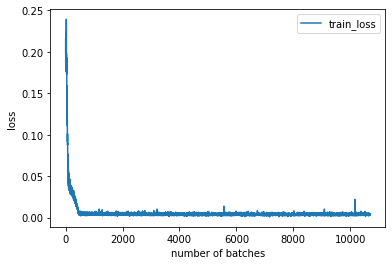

<Figure size 432x288 with 0 Axes>

In [65]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.2torchRNNtrainloss.jpg')
#plt.clf()

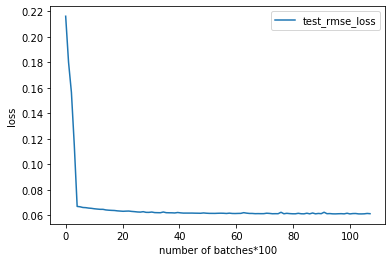

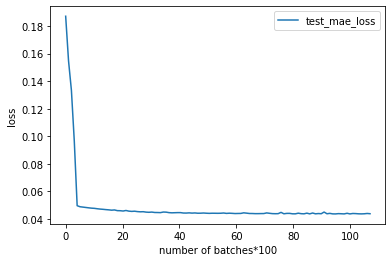

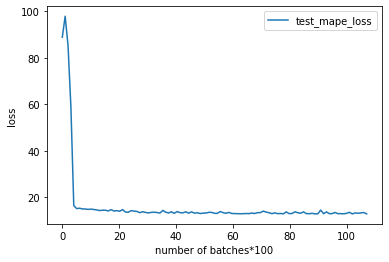

<Figure size 432x288 with 0 Axes>

In [66]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.2torchRNNtestrmseloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.2torchRNNtestrmaeloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.2torchRNNtestrmapeloss.jpg')
#plt.clf()